# ASTR 19 – Santa Cruz Tidal Project

This notebook is for the group project. I was not able to work with the group so I did it on my own. Hope that is okay.


## 1. Imports and Data Loading

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

%matplotlib inline


In [2]:
# Load the provided tide data file 
#Thi is for the first part of sparsing all the data 
filename = "ASTR19_F25_group_project_data.txt"

# File format:
# Column A: Day 
# Column B: Time in hours:minutes (H:M)
# Column C: Tide height in feet (ft)

data = pd.read_csv (
    filename, sep = r"\s+", header = None, names = ["Day", "Time", "Height_ft"], engine = "python", comment = "#"
)

def parse_time(t):
    hr, mn = t.split(":")
    return int(hr) + int(mn)/60

data["Hours"] = data["Time"].apply(parse_time)
data["t_hours"] = (data["Day"] - 1) * 24 + data["Hours"]

t = data["t_hours"].values
h = data["Height_ft"].values

data.head()


,Day,Time,Height_ft,Hours,t_hours
0,1,8:07,6.57,8.116667,8.116667
1,1,15:37,-0.39,15.616667,15.616667
2,2,8:55,5.38,8.916667,32.916667
3,2,16:25,-1.74,16.416667,40.416667
4,3,9:45,5.26,9.750000,57.750000


## 2. Oscillatory Tide Model

We use a two-component oscillatory model We have two different terms for this.

In [3]:
# Fixed tidal periods (hours)

# semi-diurnal
P1 = 12.42   
# diurnal inequality
P2 = 24.07   

def tide_model(t, C, A1, phi1, A2, phi2):
    return (C + A1 * np.cos(2 * np.pi * t / P1 + phi1) + A2 * np.cos(2 * np.pi * t / P2 + phi2))


## 3. Fit the Model (σ_meas = 0.25 ft)

I assumed a root-mean-squared measurement uncertainty of 0.25 ft for each tide measurement and perform a weighted least-squares fit using `scipy.optimize.curve_fit`.

In [4]:
# ft
sigma_meas = 0.25  
sigma_array = np.full_like(h, sigma_meas, dtype = float)

# Parameter guesses 
p0 = [np.mean(h), 3.0, 0.0, 1.0, 0.0]

popt, pcov = curve_fit(
    tide_model, t, h, p0 = p0, sigma = sigma_array, absolute_sigma = True, maxfev = 10000
)

C_fit, A1_fit, phi1_fit, A2_fit, phi2_fit = popt
perr = np.sqrt(np.diag(pcov))

print("Most accurate parameters are:")
for name, val, err in zip(["C", "A1", "phi1", "A2", "phi2"], popt, perr):
    print(f"{name} = {val:.3f} ± {err:.3f}")


Most accurate parameters are:
C = 2.529 ± 0.032
A1 = 1.037 ± 0.081
phi1 = 1.059 ± 0.090
A2 = 2.188 ± 0.067
phi2 = -1.452 ± 0.028


## 4. Plot Data and Model

This is to save the figure and make it a pdf.

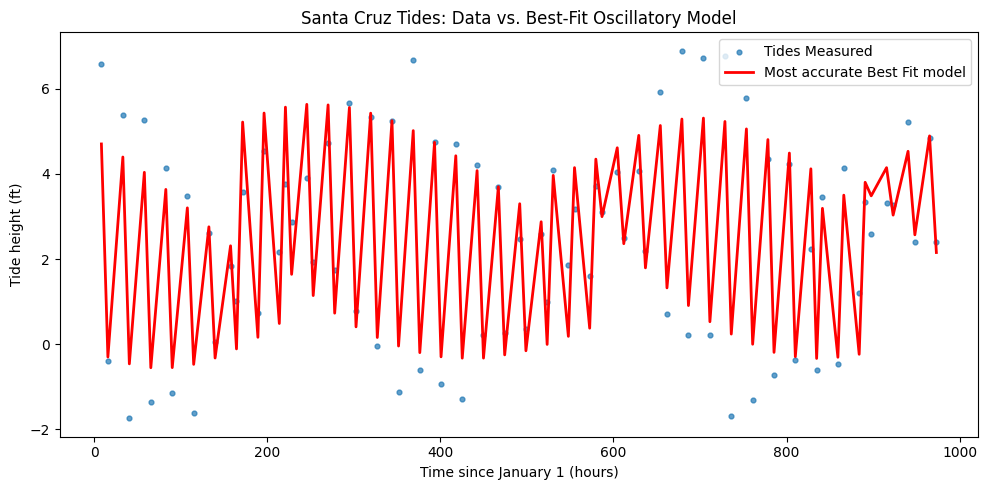

In [5]:
h_model = tide_model(t, *popt)

plt.figure(figsize = (10,5))
plt.scatter(t, h, s = 12, alpha = 0.7, label = "Tides Measured")
plt.plot(t, h_model, "r", linewidth = 2, label = "Most accurate Best Fit model")

plt.xlabel("Time since January 1 (hours)")
plt.ylabel("Tide height (ft)")
plt.title("Santa Cruz Tides: Data vs. Best-Fit Oscillatory Model")
plt.legend()
plt.tight_layout()
plt.savefig("tide_fit_plot.pdf")
plt.show()


## 5. Residuals and Scatter

We create the subtraction and measure the residuals then scatter them

In [6]:
residual = h - h_model

sigma_data = np.std(residual, ddof = 1)
sigma_intrinsic = np.sqrt(max(0.0, sigma_data ** 2 - sigma_meas ** 2))

print(f"Standard deviation of residuals is(sigma_data): {sigma_data:.3f} ft")
print(f"Assumed measurement error is (sigma_meas): {sigma_meas:.3f} ft")
print(f"Estimated intrinsic scatter is: {sigma_intrinsic:.3f} ft")


Standard deviation of residuals is(sigma_data): 0.913 ft
Assumed measurement error is (sigma_meas): 0.250 ft
Estimated intrinsic scatter is: 0.878 ft


### Residual Histogram

Now we make the residual pdf

Using 10 bins for residual histogram.


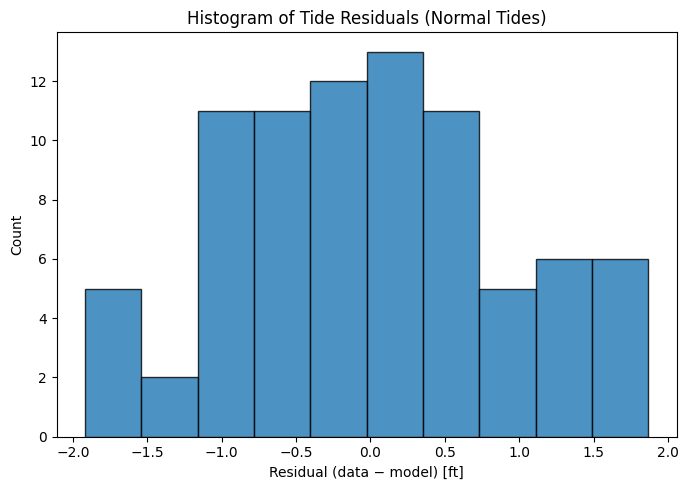

In [7]:
N = len(residual)
q25, q75 = np.percentile(residual, [25, 75])
IQR = q75 - q25
bin_width = 2 * IQR / (N ** (1/3))
n_bins = max(10, int((residual.max() - residual.min()) / bin_width))

print(f"Using {n_bins} bins for residual histogram.")

# This is where the plotting beigns 
plt.figure(figsize=(7,5))
plt.hist(residual, bins = n_bins, edgecolor = "black", alpha = 0.8)
plt.xlabel("Residual (data − model) [ft]")
plt.ylabel("Count")
plt.title("Histogram of Tide Residuals (Normal Tides)")
plt.tight_layout()
plt.savefig("residual_histogram.pdf")
plt.show()


## 6. Tsunami Deviation in σ Units

During the first high-tide of January 14, the tsunami from the underwater eruption of the Hunga Tonga-Hunga Ha'apai volcano reached the shores of Santa Cruz. The tsunami increased water levels near high tide by about 2ft. How large of a deviation is this tsunami, in terms of standard deviations of the distribution of normal tides from the model? Add a single 2ft outlier to the histogram of data and replot it as part of your Jupyter notebook

In [8]:
# ft
tsunami_residual = 2.0  

sigma_total = np.sqrt(sigma_meas ** 2 + sigma_intrinsic ** 2)
z_tsunami = tsunami_residual / sigma_total

print(f"Total scatter sigma_total is: {sigma_total:.3f} ft")
print(f"For this the Tsunami deviation is: {tsunami_residual:.1f} ft")
print(f"The Tsunami significance is: {z_tsunami:.2f} sigma")


Total scatter sigma_total is: 0.913 ft
For this the Tsunami deviation is: 2.0 ft
The Tsunami significance is: 2.19 sigma


### Histogram with Tsunami Outlier

The new plot of the Tsunami Outlier 

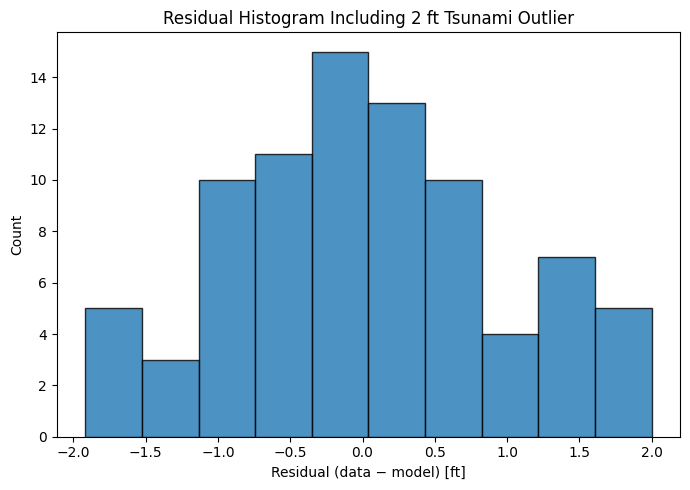

In [9]:
residual_with_tsunami = np.append(residual, tsunami_residual)

plt.figure(figsize=(7,5))
plt.hist(residual_with_tsunami, bins = n_bins, edgecolor = "black", alpha = 0.8)
plt.xlabel("Residual (data − model) [ft]")
plt.ylabel("Count")
plt.title("Residual Histogram Including 2 ft Tsunami Outlier")
plt.tight_layout()
plt.savefig("residual_histogram_with_tsunami.pdf")
plt.show()
